In [117]:
import os
import sys
from pathlib import Path
sys.path.append(os.path.dirname(os.path.abspath(Path.cwd())))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.over_sampling import SMOTE 
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, accuracy_score, make_scorer
# from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.metrics import plot_confusion_matrix


## Load the Dataset

We will load the basic stats dataset from user 1 that we create in the analysis.ipynb notebook, and split the dataset into the train set and the test set. Since out dataset is very imbalance, we will be using SMOTE to peform oversampling on the data.

In [118]:
# load the dataset to a pandas df
data = pd.read_csv("../data/train_data/basic_stats/subject_1.csv")
data.head()

,min_x,max_x,mean_x,std_x,range_x,min_y,max_y,mean_y,std_y,range_y,min_z,max_z,mean_z,std_z,range_z,activity
0,1940,1986,1961.088462,7.673593,46,2365,2396,2377.584615,5.437301,31,2086,2143,2115.726923,11.339209,57,1
1,1925,1999,1956.119231,12.374358,74,2340,2409,2379.503846,9.438890,69,2062,2168,2106.846154,18.925973,106,1
2,1919,1999,1953.280769,12.488837,80,2340,2409,2380.869231,9.430001,69,2062,2168,2101.476923,17.485666,106,1
3,1919,1977,1959.707692,10.208972,58,2368,2394,2379.800000,5.014881,26,2077,2138,2107.876923,10.598328,61,1
4,1941,1980,1964.134615,5.983339,39,2369,2390,2378.407692,3.633172,21,2086,2135,2113.100000,6.042130,49,1


In [119]:
# transform the dataset to numpy arrays
X = data.loc[:, data.columns != 'activity']
y = data['activity']
# initialize SMOTE object for oversampling
sm = SMOTE(random_state=42)
# split the dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)
# fix the imbalance issue in the train dataset
X_train, y_train = sm.fit_resample(X, y)

## Set up a BaseLine model

We will be using a Linear Classifier as our baseline model.

In [120]:
# Initialize the regresstion
reg = linear_model.LogisticRegression(solver='lbfgs', max_iter=1000)
#scale the data first
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
# fit the model
reg.fit(X_scaled, y_train)
y_pred = reg.predict(X_test_scaled)
# Print out the report
print(classification_report(y_train, reg.predict(X_scaled)))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       644
           2       0.95      1.00      0.97       644
           3       0.73      0.78      0.75       644
           4       0.92      0.88      0.90       644
           5       1.00      1.00      1.00       644
           6       0.91      0.92      0.92       644
           7       0.76      0.68      0.71       644

    accuracy                           0.89      4508
   macro avg       0.89      0.89      0.89      4508
weighted avg       0.89      0.89      0.89      4508

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        74
           2       0.25      1.00      0.40         2
           3       0.23      0.73      0.35        22
           4       0.96      0.84      0.90        62
           5       0.86      1.00      0.92         6
           6       0.30      0.60      0.40         5
           7       0.96 

/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


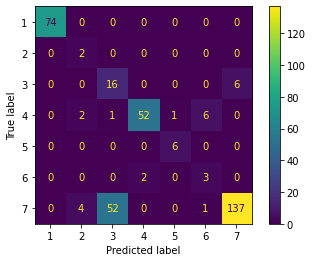

In [121]:
# plot confusion matrix
plot_confusion_matrix(reg, X_test_scaled, y_test) 
plt.show()

The Logistic Regression Classifier was able to predict accurately 92% of the sequence's labels. It was able to seperate activities 1, 3, and 7 quite successfully, but did poorly on other activities. We will try out several more classifiers and hopefully we'll get a better result than the baseline model.

## Tree-based Classifier

In this section, we will try to fit a tree-based classification model on our dataset to see if we can outperform the baseline model. First, we will start with the random forest model:

In [122]:
# initialize a RF model
rf = RandomForestClassifier(max_depth=10, random_state=5)
# fit the model on the train dataset
rf.fit(X_train, y_train)
# predict the test dataset
y_pred = rf.predict(X_test)
# Print out the report
# print(classification_report(y_train, reg.predict(X_scaled)))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        74
           2       1.00      1.00      1.00         2
           3       0.69      1.00      0.81        22
           4       1.00      1.00      1.00        62
           5       1.00      1.00      1.00         6
           6       1.00      1.00      1.00         5
           7       1.00      0.95      0.97       194

    accuracy                           0.97       365
   macro avg       0.96      0.99      0.97       365
weighted avg       0.98      0.97      0.97       365



/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


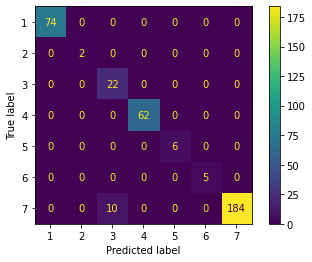

In [123]:
# plot confusion matrix
plot_confusion_matrix(rf, X_test, y_test) 
plt.show()

We can see that there's big improvements in the accuracy anf f1 score, especially this model was able to classify between activity 3 and 6 much better than the baseline model. However, we still want to see if we can increase this improvement further. Next, let's try the XGBoost model, a well-known classifier known for being good at problems like this.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        74
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00        22
           3       1.00      1.00      1.00        62
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00       194

    accuracy                           1.00       365
   macro avg       1.00      1.00      1.00       365
weighted avg       1.00      1.00      1.00       365



/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


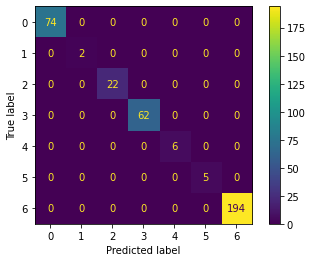

In [124]:
# initialize XGBoost classifier
xgb = XGBClassifier()
# transform the y_train and Y-test class values to start from 0 instead of 1
y_transformed_train = [i - 1 for i in y_train]
y_transformed_test = [i - 1 for i in y_test]
# fit the model
xgb.fit(X_train, y_transformed_train)
# predict the test dataset
y_pred = xgb.predict(X_test)
# print out the report
print(classification_report(y_transformed_test, y_pred))
# draw the confusion matrix
plot_confusion_matrix(xgb, X_test, y_transformed_test) 
plt.show()

The XGBoost model was able to predict accurately 100% of the test cases.